In [493]:
import tensorflow as tf
import os

In [494]:
gpus=tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import cv2


In [496]:
import imghdr


In [497]:
data_dir = 'Data'

In [498]:
image_exts = ['jpeg','jpg','bmp','png']

In [499]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image{}'.format(image_path))

Image not in ext list Data\1 Plastic\80-plastic-pollution-could-be-eradicated-by-2040-with-appropriate-policy-changes-unep-report.jpg
Image not in ext list Data\1 Plastic\Plastic-Waste.webp


In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [502]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 1331 files belonging to 4 classes.


In [503]:
data_iterator = data.as_numpy_iterator()

In [504]:
batch = data_iterator.next()

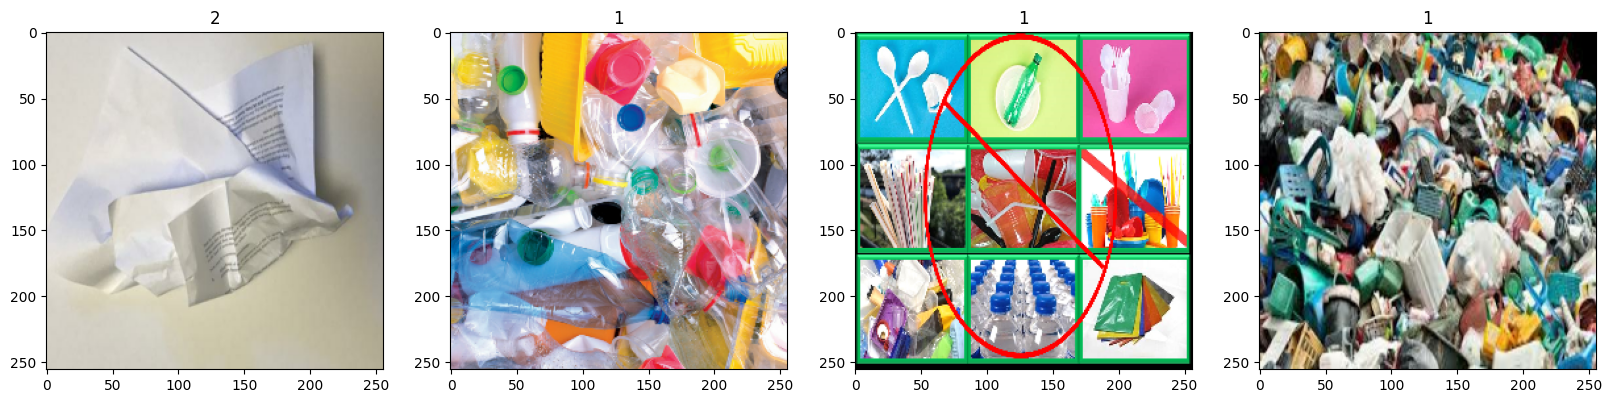

In [505]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [506]:
data = data.map(lambda x,y: (x/255.0, y))

In [507]:
len(data)

42

In [508]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [509]:
train = data.take(train_size)
val = data.skip(train_size).take(test_size)
test = data.skip(train_size+val_size).take(test_size)

In [510]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [511]:
model = Sequential()

In [512]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))


In [513]:
num_classes = 4

In [514]:
model.add(Dense(num_classes, activation='softmax'))

In [515]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [516]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 30, 30, 16)       

In [517]:
logdir='logs'

In [518]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [519]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
29/29 [==============================] - 20s 654ms/step - loss: 1.1461 - accuracy: 0.4537 - val_loss: 0.9488 - val_accuracy: 0.5500
Epoch 2/20
29/29 [==============================] - 19s 650ms/step - loss: 0.7937 - accuracy: 0.6584 - val_loss: 0.7945 - val_accuracy: 0.6250
Epoch 3/20
29/29 [==============================] - 20s 659ms/step - loss: 0.6802 - accuracy: 0.7058 - val_loss: 0.7568 - val_accuracy: 0.7250
Epoch 4/20
29/29 [==============================] - 19s 655ms/step - loss: 0.5987 - accuracy: 0.7629 - val_loss: 0.6669 - val_accuracy: 0.7437
Epoch 5/20
29/29 [==============================] - 19s 651ms/step - loss: 0.5088 - accuracy: 0.8093 - val_loss: 0.8264 - val_accuracy: 0.6562
Epoch 6/20
29/29 [==============================] - 20s 656ms/step - loss: 0.5031 - accuracy: 0.7974 - val_loss: 0.4999 - val_accuracy: 0.7937
Epoch 7/20
29/29 [==============================] - 19s 645ms/step - loss: 0.4188 - accuracy: 0.8416 - val_loss: 0.7148 - val_accuracy: 0.7125

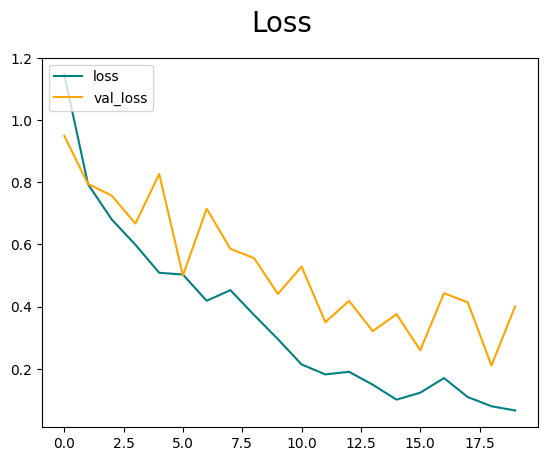

In [520]:
fig =plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

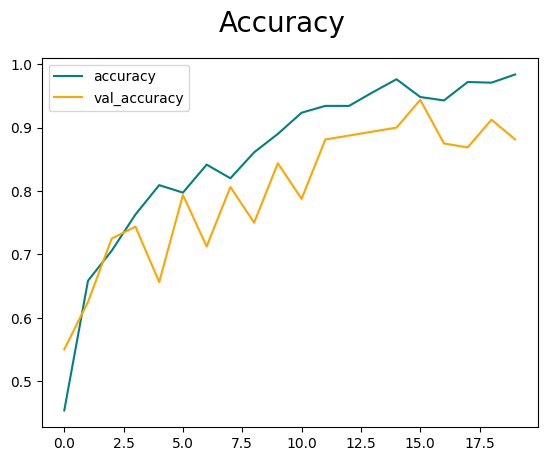

In [521]:
fig =plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [522]:
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

In [523]:
sparse_categorical_accuracy = SparseCategoricalAccuracy()
precision = Precision()
recall = Recall()

In [524]:
true_positives = 0
false_positives = 0
false_negatives = 0
total_samples = 0

In [525]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_true = y
    y_pred = np.argmax(yhat, axis=1)
    true_positives += np.sum(y_true == y_pred)
    false_positives += np.sum((y_true != y_pred))
    false_negatives += np.sum((y_true != y_pred))
    total_samples += len(y_true)

1/1 [==============================] - 0s 130ms/step


In [526]:
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
accuracy = true_positives / total_samples

In [527]:
len(test)

5

In [528]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.8367346938775511
Precision: 0.8367346938775511
Recall: 0.8367346938775511


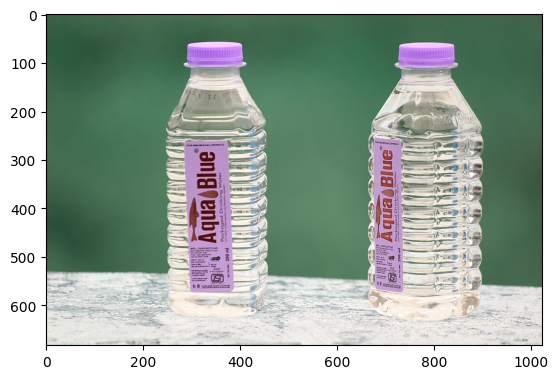

In [8]:
img = cv2.imread('Plastictest.jpg')
plt.imshow(img)
plt.show()

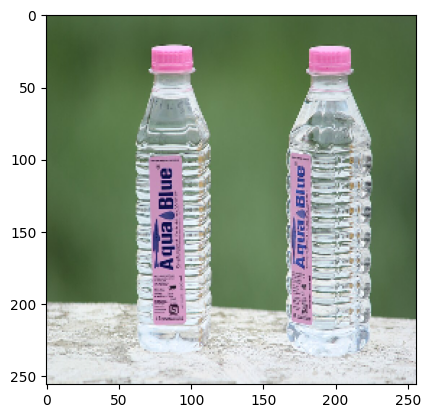

In [7]:
img = cv2.resize(img, (256, 256))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [531]:
img = img / 255.0 

In [532]:
yhat = model.predict(np.expand_dims(img, axis=0))

1/1 [==============================] - 0s 32ms/step


In [533]:
predicted_class = np.argmax(yhat)

In [534]:
print(f'Predicted Class Index: {predicted_class}')

Predicted Class Index: 1


In [535]:
from tensorflow.keras.models import load_model

In [537]:
model.save(os.path.join('models','testmodel2.h5'))